In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import scipy.stats as st

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, distinct

In [4]:
# create engine to hawaii.sqlite
engine = create_engine('sqlite:///Resources/hawaii.sqlite')

In [5]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [6]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)

# reflect the tables
Base.prepare(engine, reflect=True)

C:\ProgramData\Anaconda3\lib\site-packages\sqlalchemy\orm\clsregistry.py:176: SAWarning: This declarative base already contains a class with the same class name and module name as sqlalchemy.ext.automap.measurement, and will be replaced in the string-lookup table.
  util.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sqlalchemy\orm\clsregistry.py:176: SAWarning: This declarative base already contains a class with the same class name and module name as sqlalchemy.ext.automap.station, and will be replaced in the string-lookup table.
  util.warn(


In [7]:
# View all of the classes that automap found
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Use Inspector to print the column names and types for Measurement and Station
columns_a = inspector.get_columns('Measurement')
for c in columns_a:
    print(c['name'], c['type'])
print('-'*5)
columns_b = inspector.get_columns('Station')
for c in columns_b:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
-----
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
recent_date

('2017-08-23',)

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# Calculate the date one year from the last date in data set.
one_year = dt.date(2017,8,23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
prcp_data = session.query(Measurement.date,Measurement.prcp).\
            filter((Measurement.date>=one_year)\
                   &(Measurement.date<=dt.date(2017,8,23))).all()
date = [result[0] for result in prcp_data[:366]]
prcp = [result[1] for result in prcp_data[:366]]

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_data,columns=['date', 'prcp']).sort_values('date').set_index('date')
prcp_df.rename(columns={'prcp':'Precipitation'}, inplace=True)

prcp_df.head()

,Precipitation
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


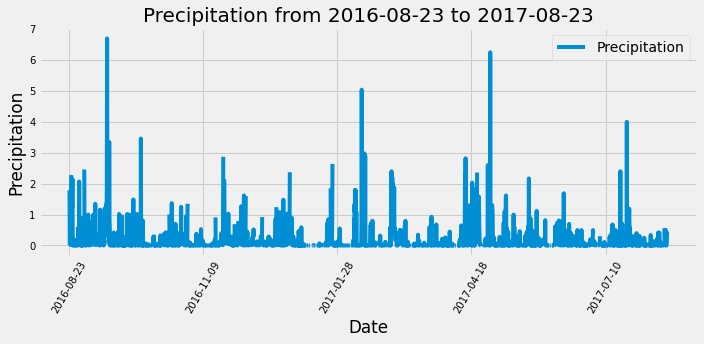

In [13]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(figsize=(10,5), fontsize=10, rot=60)
plt.title(f'Precipitation from {one_year} to {dt.date(2017,8,23)}', fontsize=20)
plt.xlabel('Date')
plt.ylabel('Precipitation')

plt.tight_layout()
plt.savefig('Images/precipitation_data_bargraph.png')
plt.show()

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_data = prcp_df['Precipitation'].describe()
summary_statistics = pd.DataFrame(precipitation_data)
summary_statistics

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number stations in the dataset
station_count = session.query(Station.station).count()
station_count

9

In [16]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station,func.count(Measurement.station)).\
                                group_by(Measurement.station).\
                                order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations[0][0]
print (f'The most active station id is {most_active_station}.')
print('-'*5)

# Calculate lowest temperature
lowest_temp = session.query(func.min(Measurement.tobs)).\
              filter(Measurement.station == most_active_station).scalar()
print(f"Lowest temperature: {lowest_temp} degrees Fahrenheit.")

# Calculate highest temperature
highest_temp = session.query(func.max(Measurement.tobs)).\
              filter(Measurement.station == most_active_station).scalar()
print(f"Highest temperature: {highest_temp} degrees Fahrenheit.")

# Calculate average temperature
avg_temp = session.query(func.avg(Measurement.tobs)).\
              filter(Measurement.station == most_active_station).scalar()
print(f"Average temperature: {round(avg_temp, 2)} degrees Fahrenheit.")

The most active station id is USC00519281.
-----
Lowest temperature: 54.0 degrees Fahrenheit.
Highest temperature: 85.0 degrees Fahrenheit.
Average temperature: 71.66 degrees Fahrenheit.


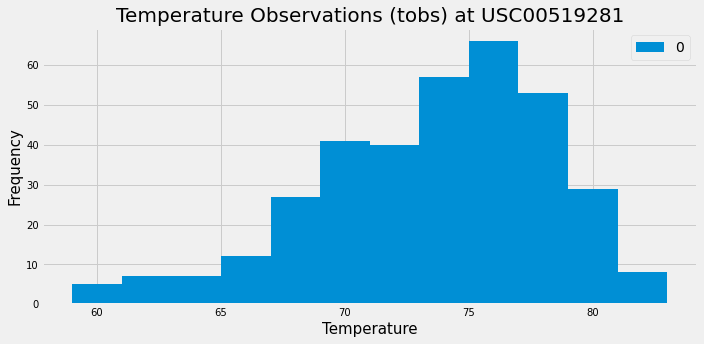

In [18]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Query the last 12 months of temperature observation date for station id USC00519281
most_active_tobs = pd.DataFrame(session.query(Measurement.tobs).\
                                filter((Measurement.station == most_active_station)\
                                        & (Measurement.date >= one_year)\
                                        & (Measurement.date <= dt.date(2017,8,23))).all())

# Plot query results as a histogram
most_active_tobs.plot(kind="hist", figsize=(10,5), bins=12, legend=True)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("Temperature", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.title(f"Temperature Observations (tobs) at {most_active_station}", fontsize=20)

plt.tight_layout()
plt.savefig("Images/tobs_histogram.png")
plt.show()

# Close session

In [19]:
# Close Session
session.close()